# Notebook 6: Phases of the Ising Model with Logistic Regression


# Coding a logistic regression from scratch (no packages allowed :)

In [166]:
import warnings
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# logistic function
def logistic(x):
    return 1/(1+np.exp(-x))

# classification error function
def class_error(X,y,params):
    return 100*np.mean(np.abs((logistic(np.dot(X,params))>0.5)-y))
    
# gradient of logistic regression with L2 penalization (the rows of X must be the data samples)
def grad_log(X,y,params,lamb):   
    return np.sum(np.array([(logistic(np.dot(X[i,:],params))-y[i])*X[i,:] for i in range(y.shape[0])])+lamb*params,0)

# divide the data in mini batches
def mini_batch(X,y,size_batch,number_batch):
    perm=np.random.permutation(X.shape[0])
    randX=X[perm,:]
    randy=y[perm]        
    
    X_mini=np.array([randX[i*size_batch:min(i*size_batch+size_batch,X.shape[0]),:] for i in range(number_batch)])
    y_mini=np.array([randy[i*size_batch:min(i*size_batch+size_batch,X.shape[0])] for i in range(number_batch)])
    return X_mini,y_mini


# SGD with momentum or NAG
def SGD(X,y,grad,init,epochs=30,learn_rate=10**-4,momentum=0.9,L2_pen=0.01,nag=1,size_batch=1,ground_truth=0,print_freq=-1):
    params=np.array(init)
    v=0 
    number_batch=int(np.ceil(X.shape[0]/size_batch))
    
    for j in range(epochs):   
        X_mini,y_mini=mini_batch(X,y,size_batch,number_batch)
    
        for k in range(number_batch):
            if nag==0:
                v=momentum*v+learn_rate*np.array(grad(X_mini[k],y_mini[k],params,L2_pen))
                params=params-v
            else:        
                params_nesterov=params-momentum*v
                v=momentum*v+learn_rate*np.array(grad(X_mini[k],y_mini[k],params_nesterov,L2_pen))
                params=params-v
            
        train_er=class_error(X,y,params)
        if ground_truth.shape[0]>1 and j%print_freq==1:
            print(['epoch',j,'train error',train_er,'overlap',np.dot(ground_truth,params)/np.dot(ground_truth,ground_truth)])           
        elif j%print_freq==1:
            print(['epoch',j,'train error',train_er])         
            
    return params

In [192]:
data_set='mnist'
n_train=5000
n_test=8000
N=1000 # number of features (not taken into account when data_set='mnist')
sparsity=0 # fraction of zero components in the linear classifier, for data_set='linear'
learn_rate=1e-4
size_batch=10
nag=1 # NAG or momentum SGD
L2_pen=0.01 # L2 penalization
epochs=30
init=np.zeros(N) # initialization, try also np.random.normal(X_train.shape[1])
print_freq=-1
load_mnist=0

if data_set=='linear':
    # linearly separable data
    classifier=np.random.normal(size=N)*(np.random.uniform(0,1,size=N)>=sparsity)
    X=np.random.normal(size=(n_train+n_test,N))
    y=(1+np.sign(np.dot(X,classifier)))/2
elif data_set=='sphere':
    # non linearly separable data  
    classifier=np.array([])
    X=np.random.normal(size=(n_train+n_test,N))
    y=np.array([int(np.linalg.norm(X[i,:])<np.sqrt(N)) for i in range(n_train+n_test)])
elif data_set=='mnist':
    N=784 # number of pixels/features
    init=np.zeros(N)
    
    # load MNIST data from https://www.openml.org/d/554    
    if load_mnist:
        from sklearn.datasets import fetch_openml # MNIST data
        X_mnist,y_mnist=fetch_openml('mnist_784',version=1,return_X_y=True)
    
    # select subset of two numbers
    number_1='3'
    number_2='4'
    select=np.where((y_mnist==number_1)|(y_mnist==number_2))
    X,y=np.array(X_mnist[select[0],:]),np.array(y_mnist[select[0]])    
    y[y==number_1]=0
    y[y==number_2]=1
    y=y.astype('float')

# pick training and test data sets 
perm=np.random.permutation(X.shape[0])
X,y=X[perm,:],y[perm]
X_train,X_test,y_train,y_test=train_test_split(X,y,train_size=n_train,test_size=n_test)

# scale data to have zero mean and unit variance 
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

# home-made SGD solver
params=SGD(X_train,y_train,grad_log,init,epochs=epochs,learn_rate=learn_rate,momentum=0.9,L2_pen=L2_pen,nag=nag,size_batch=size_batch,ground_truth=classifier,print_freq=print_freq)

# sklearn SGD solver
from sklearn import linear_model
logreg_SGD=linear_model.SGDClassifier(loss='log',penalty='l2',alpha=L2_pen,max_iter=max_epoch,shuffle=True,random_state=1,learning_rate='optimal')
logreg_SGD.fit(X_train,y_train)

# check accuracy
print(['% train error home made SGD logistic regresssion', class_error(X_train,y_train,params)])
print(['% test error home made SGD logistic regresssion', class_error(X_test,y_test,params)])
print(['% train error sklearn SGD logistic regresssion', class_error(X_train,y_train,logreg_SGD.coef_[0,:])])
print(['% test error sklearn SGD logistic regresssion', class_error(X_test,y_test,logreg_SGD.coef_[0,:])])

['% train error home made SGD logistic regresssion', 0.24]
['% test error home made SGD logistic regresssion', 0.8125]
['% train error sklearn SGD logistic regresssion', 1.28]
['% test error sklearn SGD logistic regresssion', 1.7375000000000003]


# Learning Goal
The goal of this notebook is to show how one can employ Logistic Regression to classify the states of the 2D Ising model according to their phase. We will discuss overfitting, regularization, and learn how to use the scikit-learn library. We will also examine the role of the optimizer in making predictions.

## Overview

The energy function of the classical Ising model is given by

$$ H = -J\sum_{\langle ij\rangle}S_{i}S_j,\qquad \qquad S_j\in\{\pm 1\} $$

where the lattice site indices $i,j$ run over all nearest neighbors of a 2D square lattice, and $J$ is some arbitrary interaction energy scale. We adopt periodic boundary conditions. Onsager proved that this model undergoes a thermal phase transition in the thermodynamic limit from an ordered ferromagnet with most spins aligned to a disordered phase at the critical temperature $T_c/J=2/\log(1+\sqrt{2})\approx 2.26$. For any finite system size, this critical point is expanded to a critical region around $T_c$.


An interesting question to ask is whether one can train a statistical model to distinguish between the two phases of the Ising model. If successful, this can be used to locate the position of the critical point in more complicated models where an exact analytical solution has so far remained elusive. 

In other words, given an Ising state, we would like to classify whether it belongs to the ordered or the disordered phase, without any additional information other than the spin configuration itself. This categorical machine learning problem is well suited for logistic regression. Notice that, for the purposes of applying logistic regression, the 2D spin state of the Ising model will be flattened out to a 1D array, so it will not be easy to learn information about the structure of the contiguous ordered 2D domains [see figure below]. Such information can be incorporated using other methods such as multi-layer deep convolutional neural networks (CNNs), see Secs. IX, X and XI of the review and the corresponding notebooks.

## The 2D Ising Dataset

To this end, we consider the 2D Ising model on a $40\times 40$ square lattice, and use Monte-Carlo (MC) sampling to prepare $10^4$ states at every fixed temperature $T$ out of a pre-defined set $T\in[0.25,0.5,\cdots,4.0]$. Using Onsager's criterion, we can assign a label to each state according to its phase: $0$ if the state is disordered, and $1$ if it is ordered. Our goal is to predict the phase of a sample given the spin configuration.

It is well-known that, near the critical temperature $T_c$, the ferromagnetic correlation length diverges which, among other things, leads to a critical slowing down of the MC algorithm. Therefore, we expect identifying the phases to be harder in the critical region. With this in mind, consider the following three types of states: ordered ($T/J<2.0$), critical ($2.0\leq T/J\leq 2.5)$ and disordered ($T/J>2.5$). We use both ordered and disordered states to train the logistic regressor and once the supervised training procedure is complete, we evaluate the performance of our classification model on unseen ordered, disordered and critical states. 

In [193]:
import numpy as np

import warnings
warnings.filterwarnings('ignore')

np.random.seed() # shuffle random seed generator

# Ising model parameters
L=40 # linear system size
J=-1.0 # Ising interaction
T=np.linspace(0.25,4.0,16) # set of temperatures
T_c=2.26 # Onsager critical temperature in the TD limit

# Loading in the Ising dataset
We now load in the data which is hosted on Pankaj Mehta's [website](http://physics.bu.edu/~pankajm/MLnotebooks.html).

In [194]:
import pickle, os
from urllib.request import urlopen 

# url to data
url_main = 'https://physics.bu.edu/~pankajm/ML-Review-Datasets/isingMC/';

######### LOAD DATA
# The data consists of 16*10000 samples taken in T=np.arange(0.25,4.0001,0.25):
data_file_name = "Ising2DFM_reSample_L40_T=All.pkl" 
# The labels are obtained from the following file:
label_file_name = "Ising2DFM_reSample_L40_T=All_labels.pkl"


#DATA
data=pickle.load(urlopen(url_main + data_file_name)) # pickle reads the file and returns the Python object (1D array, compressed bits)
data=np.unpackbits(data).reshape(-1, 1600) # Decompress array and reshape for convenience
data=data.astype('int')
data[np.where(data==0)]=-1 # map 0 state to -1 (Ising variable can take values +/-1)

#LABELS (convention is 1 for ordered states and 0 for disordered states)
labels = pickle.load(urlopen(url_main + label_file_name)) # pickle reads the file and returns the Python object (here just a 1D array with the binary labels)

# Constructing the training and the test sets

In [195]:
from sklearn.model_selection import train_test_split

###### define ML parameters
num_classes=2
train_to_test_ratio=0.5 # fraction training samples

# divide data into ordered, critical and disordered (1e4 samples for T=0.25, 1e4 for T=0.5, ... , 1e4 for T=4)
X_ordered=data[:70000,:]
Y_ordered=labels[:70000]

X_critical=data[70000:100000,:]
Y_critical=labels[70000:100000]

X_disordered=data[100000:,:]
Y_disordered=labels[100000:]

del data,labels

# define training and test data sets
X=np.concatenate((X_ordered,X_disordered))
Y=np.concatenate((Y_ordered,Y_disordered))

# pick random data points from ordered and disordered states to create the training and test sets
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,train_size=train_to_test_ratio)

# full data set
X=np.concatenate((X_critical,X))
Y=np.concatenate((Y_critical,Y))

print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print()
print(X_train.shape[0], 'train samples')
print(X_critical.shape[0], 'critical samples')
print(X_test.shape[0], 'test samples')

X_train shape: (65000, 1600)
Y_train shape: (65000,)

65000 train samples
30000 critical samples
65000 test samples


# Visualizing the states

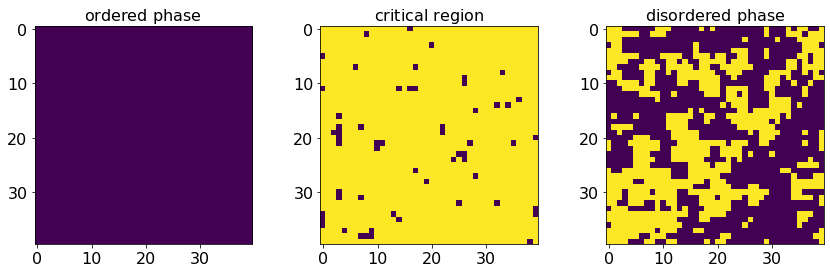

In [205]:
##### plot a few Ising states
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# plot states
fig, axarr = plt.subplots(nrows=1, ncols=3)
i=11
axarr[0].imshow(X_ordered[300*i].reshape(L,L))
axarr[0].set_title('$\\mathrm{ordered\\ phase}$',fontsize=16)
axarr[0].tick_params(labelsize=16)

axarr[1].imshow(X_critical[300*i].reshape(L,L))
axarr[1].set_title('$\\mathrm{critical\\ region}$',fontsize=16)
axarr[1].tick_params(labelsize=16)

im=axarr[2].imshow(X_disordered[300*i].reshape(L,L))
axarr[2].set_title('$\\mathrm{disordered\\ phase}$',fontsize=16)
axarr[2].tick_params(labelsize=16)

fig.subplots_adjust(right=2.0)
plt.show()

## Cost function, optimizers, regularizers, and performance metrics

In Sec. VII of the review, we have shown that the cross-entropy is a natural cost function used for training a logistic regressor. As we already mentioned, minimizing it requires the use of numerical toolboxes. Here, we compare the performance of two different optimization routines: a `liblinear` [the default one for scikit's logistic regression], and stochastic gradient descent (SGD) [see Sec. IV of the review for more details].

It is important to note that all these methods have built-in regularizers. Indeed, we did not discuss the role of the regularisor explicitly in the context of Logistic Regression extensively, yet this concept is crucial in order to prevent overfitting, and we encourage the interested reader to play with the different regularization types and regularization strengths and compare model performances. 

Below, we define the accuracy of a classification model on a given data set as the percentage of correctly classified data points. Comparing the accuracy on the training and test data, we obtain a good estimate of the degree of overfitting. Well-trained models do not overfit the data, which is reflected in an almost equal performance on the training and test data sets [recall that the test set consists of samples which the model has not been trained on]. 

# Run the cell below (this may take several minutes)

accuracy: train, test, critical
liblin: 0.7285, 0.6879, 0.6192
SGD: 0.4846, 0.4693, 0.5042
finished computing 1/11 iterations
accuracy: train, test, critical
liblin: 0.7285, 0.6879, 0.6192
SGD: 0.5321, 0.5104, 0.5510
finished computing 2/11 iterations
accuracy: train, test, critical
liblin: 0.7285, 0.6879, 0.6192
SGD: 0.4832, 0.4496, 0.4888
finished computing 3/11 iterations
accuracy: train, test, critical
liblin: 0.7285, 0.6879, 0.6192
SGD: 0.6794, 0.6375, 0.5971
finished computing 4/11 iterations
accuracy: train, test, critical
liblin: 0.7285, 0.6879, 0.6192
SGD: 0.6636, 0.6282, 0.6268
finished computing 5/11 iterations
accuracy: train, test, critical
liblin: 0.7285, 0.6879, 0.6192
SGD: 0.5395, 0.5383, 0.6672
finished computing 6/11 iterations
accuracy: train, test, critical
liblin: 0.7285, 0.6878, 0.6193
SGD: 0.5390, 0.5379, 0.6667
finished computing 7/11 iterations
accuracy: train, test, critical
liblin: 0.7278, 0.6874, 0.6206
SGD: 0.5390, 0.5379, 0.6667
finished computing 8/11 ite

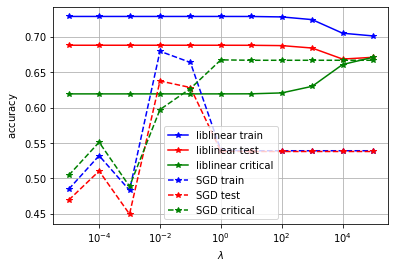

In [206]:
###### apply logistic regression
from sklearn import linear_model
from sklearn.neural_network import MLPClassifier


# define regularisation parameter
lmbdas=np.logspace(-5,5,11)

# preallocate data
train_accuracy=np.zeros(lmbdas.shape,np.float64)
test_accuracy=np.zeros(lmbdas.shape,np.float64)
critical_accuracy=np.zeros(lmbdas.shape,np.float64)

train_accuracy_SGD=np.zeros(lmbdas.shape,np.float64)
test_accuracy_SGD=np.zeros(lmbdas.shape,np.float64)
critical_accuracy_SGD=np.zeros(lmbdas.shape,np.float64)

# loop over regularisation strength
for i,lmbda in enumerate(lmbdas):

    # define logistic regressor
    logreg=linear_model.LogisticRegression(C=1.0/lmbda,random_state=1,verbose=0,max_iter=1E3,tol=1E-5,
                                           solver='liblinear')

    # fit training data
    logreg.fit(X_train, Y_train)

    # check accuracy
    train_accuracy[i]=logreg.score(X_train,Y_train)
    test_accuracy[i]=logreg.score(X_test,Y_test)
    critical_accuracy[i]=logreg.score(X_critical,Y_critical)
    
    print('accuracy: train, test, critical')
    print('liblin: %0.4f, %0.4f, %0.4f' %(train_accuracy[i],test_accuracy[i],critical_accuracy[i]) )

    # define SGD-based logistic regression
    logreg_SGD = linear_model.SGDClassifier(loss='log', penalty='l2', alpha=lmbda, max_iter=100, 
                                           shuffle=True, random_state=1, learning_rate='optimal')

    # fit training data
    logreg_SGD.fit(X_train,Y_train)

    # check accuracy
    train_accuracy_SGD[i]=logreg_SGD.score(X_train,Y_train)
    test_accuracy_SGD[i]=logreg_SGD.score(X_test,Y_test)
    critical_accuracy_SGD[i]=logreg_SGD.score(X_critical,Y_critical)
    
    print('SGD: %0.4f, %0.4f, %0.4f' %(train_accuracy_SGD[i],test_accuracy_SGD[i],critical_accuracy_SGD[i]) )

    print('finished computing %i/11 iterations' %(i+1))

# plot accuracy against regularisation strength
plt.semilogx(lmbdas,train_accuracy,'*-b',label='liblinear train')
plt.semilogx(lmbdas,test_accuracy,'*-r',label='liblinear test')
plt.semilogx(lmbdas,critical_accuracy,'*-g',label='liblinear critical')

plt.semilogx(lmbdas,train_accuracy_SGD,'*--b',label='SGD train')
plt.semilogx(lmbdas,test_accuracy_SGD,'*--r',label='SGD test')
plt.semilogx(lmbdas,critical_accuracy_SGD,'*--g',label='SGD critical')

plt.xlabel('$\\lambda$')
plt.ylabel('$\\mathrm{accuracy}$')

plt.grid()
plt.legend()
plt.show()

## Interpreting the results

The first thing we can read off the figure above is the relative degree of overfitting. This information is contained in the difference in accuracy of our model on the training (blue) and test (red) datasets. Notice that the accuracy difference between test and training sets is significant but not unreasonable, within $10\%$. Interestingly, which optimizer performs better depends on the value of the regularization strength. Moreover, similar to the Linear Regression examples, we find that there exists a sweet spot for the regularization strength $\lambda$ that results in optimal performance of the logistic regressor, at about $\lambda\sim 10^{-1}$.

Due to the physics of the Ising model close to criticality, we expect that predicting the phase of a sample will become much more difficult close to the critical point. We can visually see this by looking at the states in the critical region, (see Fig. above and plot other examples). Notice that it is no longer easy even for a trained human eye to distinguish between the ferromagnetic and the disordered phases close to $T_c$. 

It is an interesting exercise to compare the training and test accuracies in the ordered and disordered phases to the accuracy of the model near the critical point (i.e. critical states). Recall that the model is not trained on critical states. Notice that the accuracy is about $10\%$ smaller for the critical states (green curves). 


### Exercises: ###  
<ul>
<li> Change the regularization to $L^1$, or $L^1+L^2$ (i.e. elastic net, see Notebook 2 for more details), and study the performance of the model.

<li> Try out different solvers supported by `LogisticRegression()`, [see online scikit documentation](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). How do they compare to `liblinear` and `SGD`?

<li> One can expect the regressor to be maximally confused exactly at the critical point. Take the data states for the closest temperature, i.e. $T/J=2.5$, and check the performance of the model. Do we get an accuracy of about $50\%$? Does this depend on the proportion of ordered to disordered states in the training set?

<li> Take the regressor trained on the square lattice Ising model, and try to predict the phases on a different lattice geometry (e.g. triangular or honeycomb). What accuracy do you obtain? Can you roughly locate the critical point in this new model? Note that this requires you to generate your own dataset using Monte-Carlo sampling.
</ul>